In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from model_protein_moe import trans_basic_block, trans_basic_block_Config
from utils_search import *
from transformers import T5EncoderModel, T5Tokenizer
import re
import gc
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import pickle

from pathlib import Path
from dataclasses import dataclass
from typing import Union, List, Tuple, Any, Dict, Optional
import pickle
import h5py
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from collections import defaultdict
import re
from torch import nn
from torch.utils.data import DataLoader
import faiss
import os
from sklearn.metrics import f1_score, precision_score, recall_score

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/mnt/home/thamamsy/projects/protein_vec/lib/environment/protein_vec_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Protein-Vec MOE model checkpoint and config
vec_model_cpnt = '/mnt/home/thamamsy/ceph/protein_vec/models/model0.0001_dmodel512_nlayer2_moe_all/checkpoints/last-v1.ckpt'
vec_model_config = '/mnt/home/thamamsy/ceph/protein_vec/models/model0.0001_dmodel512_nlayer2_moe_all/params.json'

In [3]:
#Load the ProtTrans model and ProtTrans tokenizer
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
gc.collect()

model = model.to(device)
model = model.eval()

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [4]:
#Load the model
vec_model_config = trans_basic_block_Config.from_json(vec_model_config)
model_deep = trans_basic_block.load_from_checkpoint(vec_model_cpnt, config=vec_model_config)
model_deep = model_deep.to(device)
model_deep = model_deep.eval()

Lightning automatically upgraded your loaded checkpoint from v1.8.0rc0 to v1.9.4. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../public_www/tm_vec_swiss_model_large.ckpt`


In [5]:
### Evaluate based on sequence similarity 
# Load in uniprot meta data
meta_data_new = pd.read_csv('/mnt/home/thamamsy/ceph/protein_vec/data/uniprot_data/uniprotkb_AND_reviewed_true_2023_07_03.tsv', sep='\t')

#Load 
held_out_50 = np.load('/mnt/home/thamamsy/ceph/protein_vec/data/uniprot_data/training_splits/mmseq_splits/held_out_50_proteins.npy', allow_pickle=True)
held_out_20 = np.load('/mnt/home/thamamsy/ceph/protein_vec/data/uniprot_data/training_splits/mmseq_splits/held_out_20_proteins.npy', allow_pickle=True)

held_out_50_proteins = meta_data_new[meta_data_new['Entry'].isin(held_out_50)]
held_out_20_proteins = meta_data_new[meta_data_new['Entry'].isin(held_out_20)]

In [10]:
####### Can change this here for 50 vs. 20
###############################################
data_subset = held_out_50_proteins.reset_index()

In [11]:
print('Number of proteins')
len(data_subset)

Number of proteins


5191

In [12]:
# This is a forward pass of the Protein-Vec model
# Every aspect turned on
sampled_keys = np.array(['TM', 'PFAM', 'GENE3D', 'ENZYME', 'MFO', 'BPO', 'CCO'])
all_cols = np.array(['TM', 'PFAM', 'GENE3D', 'ENZYME', 'MFO', 'BPO', 'CCO'])

masks = [all_cols[k] in sampled_keys for k in range(len(all_cols))]
masks = torch.logical_not(torch.tensor(masks, dtype=torch.bool))[None,:]

#Pull out sequences for the new proteins
flat_seqs = data_subset['Sequence'].values

#Loop through the sequences and embed them using protein-vec
i = 0
embed_all_sequences = []
while i < len(flat_seqs): 
    protrans_sequence = featurize_prottrans(flat_seqs[i:i+1], model, tokenizer, device)
    embedded_sequence = embed_vec(protrans_sequence, model_deep, masks, device)
    embed_all_sequences.append(embedded_sequence)
    i = i + 1
    
    if i % 200 == 0:
        print(i)
        
query_embeddings = np.concatenate(embed_all_sequences)

/mnt/home/thamamsy/projects/protein_vec/lib/environment/protein_vec_env/lib/python3.9/site-packages/torch/nn/modules/transformer.py:296: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000


Now that we have embeddings for the proteins with low sequence similarity to our training proteins, we can visualize them after performing TSNE, and we can transfer annotations to them as well

In [14]:
#Perform TSNE on the embedding vectors
all_X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(query_embeddings)
all_X_embedded_df = pd.DataFrame(all_X_embedded)
all_X_embedded_df.columns = ["Dim1", "Dim2"]
all_X_embedded_df['Pfam'] = data_subset['Pfam'].values
all_X_embedded_df['EC'] = data_subset['EC number'].values

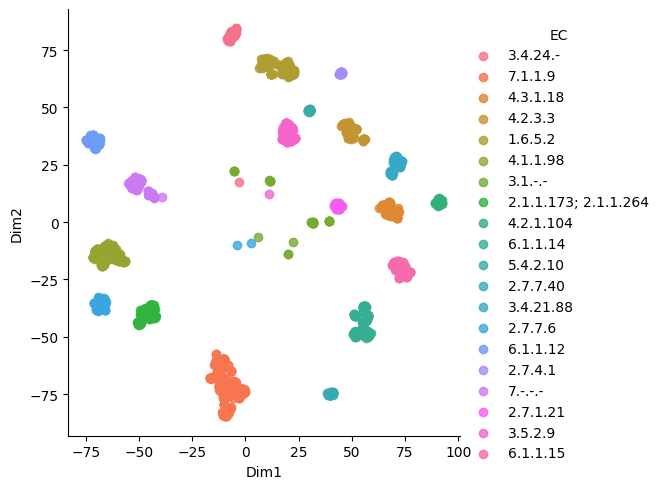

In [15]:
#For visualization purposes, filter for the top 20 EC terms
top_ranks = list(all_X_embedded_df['EC'].value_counts()[0:20].index)
sns.lmplot(x="Dim1", y="Dim2", data=all_X_embedded_df[all_X_embedded_df['EC'].isin(top_ranks)], hue="EC", fit_reg=False)


In [16]:
################## Load the lookup database of all embeddings (note that we will pull out only embeddings from proteins that were trained on)
embeddings = np.load('/mnt/home/thamamsy/projects/protein-vec/data/lookup_embeddings.npy')
lookup_proteins_meta = pd.read_csv('/mnt/home/thamamsy/projects/protein-vec/data/lookup_embeddings_meta_data.tsv', sep="\t")


We can run search and the nearest neighbor pipeline for any of our available aspects
 - 'Gene Ontology (biological process)'
 - 'Gene Ontology (molecular function)' 
 - 'Gene Ontology (cellular component)' 
 - 'Gene3D' 
 - 'Pfam' 
 - 'EC number'

In [17]:
#Switch this for whichever aspect you want to perform search for
############### User parameter
column = 'Gene Ontology (biological process)'

In [18]:
# Filter for lookup proteins with annotations for the relavant aspect (don't want to transfer null annotations)
col_lookup = lookup_proteins_meta[~lookup_proteins_meta[column].isnull()]
col_lookup_embeddings = embeddings[col_lookup.index]
col_meta_data = col_lookup[column].values

# load database
lookup_database = load_database(col_lookup_embeddings)

# Query for the 1st nearest neighbor
k = 1
D, I = query(lookup_database, query_embeddings, k)

#Get metadata for the 1st nearest neighbor
near_ids = []
for i in range(I.shape[0]):
    meta = col_meta_data[I[i]]
    near_ids.append(list(meta))       

near_ids = np.array(near_ids)

In [19]:
print("Annotations for the nearest neighbors (with aspect annotations) of newly discovered proteins")
print(near_ids)

Annotations for the nearest neighbors (with aspect annotations) of newly discovered proteins
[['determination of adult lifespan [GO:0008340]; innate immune response [GO:0045087]; magnesium ion homeostasis [GO:0010960]; magnesium ion transport [GO:0015693]; positive regulation of gonad development [GO:1905941]; positive regulation of multicellular organism growth [GO:0040018]; positive regulation of vulval development [GO:0040026]; response to magnesium ion [GO:0032026]']
 ['fatty acid metabolic process [GO:0006631]; sphingolipid metabolic process [GO:0006665]']
 ['endoplasmic reticulum unfolded protein response [GO:0030968]; lipoprotein metabolic process [GO:0042157]; lipoprotein transport [GO:0042953]; plasma lipoprotein particle assembly [GO:0034377]']
 ...
 ['deoxyribonucleotide catabolic process [GO:0009264]']
 ['ubiquinone biosynthetic process [GO:0006744]']
 ['archaeal or bacterial-type flagellum-dependent cell motility [GO:0097588]']]


In [21]:
# Calculate the recall (sensitivity) performance results for every aspect
if column == 'EC number':
    ground_meta_data = data_subset[(~data_subset[column].isnull()) & (~data_subset[column].astype(str).str.contains('-', regex=False))]
else:
    ground_meta_data = data_subset[(~data_subset[column].isnull())]

rel_col = ground_meta_data[column].values
relevant_indices = np.array(list(ground_meta_data.index))
relevant_near_ids = near_ids[relevant_indices]
relevant_D = D[relevant_indices]

#this calculates exact match
intersection = []
for i in range(len(rel_col)):
    p1s = set(rel_col[i].split(";"))
    p1s = {item for item in p1s if item != ""}
    p2s = set(relevant_near_ids[i,0].split(";"))
    p2s = {item for item in p2s if item != ""}
    inter = len(list(p1s & p2s))
    acc = inter/len(p1s)
    intersection.append(acc)

    
#Exact match accuracy
exact_matches = 0
for i in range(len(rel_col)):
    p1s = set(rel_col[i].split(";"))
    p2s = set(relevant_near_ids[i,0].split(";"))
    if p1s == p2s:
        exact_matches += 1

In [24]:
print("Gene Ontology (biological process): Recall of protein MOE model for annotating proteins with sequence similarity below 50%")
print(np.mean(np.array(intersection)))

Gene Ontology (biological process): Recall of protein MOE model for annotating proteins with sequence similarity below 50%
0.7533442184946648


In [25]:
print("Gene Ontology (biological process): Exact match accuracy of protein MOE model for annotating proteins with sequence similarity below 50%")
print(exact_matches/len(rel_col))

Gene Ontology (biological process): Exact match accuracy of protein MOE model for annotating proteins with sequence similarity below 50%
0.6657317695053544
